In [1]:
%cd /content/sample_data

/content/sample_data


In [2]:
import pandas as pd
import numpy as np

In [3]:
churn=pd.read_excel('churn_pred_clean (1).xlsx')

In [ ]:
churn.head(5)

,France,Germany,Spain,gender,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,1,0,0,0,619,42,2,0.00,1,1,1,101348.88,1
1,0,0,1,0,608,41,1,83807.86,1,0,1,112542.58,0
2,1,0,0,0,502,42,8,159660.80,3,1,0,113931.57,1
3,1,0,0,0,699,39,1,0.00,2,0,0,93826.63,0
4,0,0,1,0,850,43,2,125510.82,1,1,1,79084.10,0


In [4]:
y=churn['churn']
X=churn.drop('churn',axis=1,inplace=False)

In [117]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [5]:
import torch

In [6]:
y=torch.from_numpy(np.array(y)).float()
X=torch.from_numpy(np.array(X)).float()

In [56]:
for i in range(X.shape[1]): #her sutun için
  the_min=torch.min(X[:,i])
  the_max=torch.max(X[:,i])
  X[:,i]=(X[:,i]-the_min)/(the_max-the_min+0.00000000001)
#0.00000000001 =1e-11

In [17]:
from sklearn.model_selection import train_test_split
X_egitim, X_gecici, y_egitim, y_gecici = train_test_split(
    X, y, test_size=0.5, shuffle=True, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_gecici, y_gecici, test_size=0.5, random_state=42)

In [11]:
X_egitim.shape

(5000, 12)

In [8]:
import torch.nn as nn
import torch.optim as optim

In [63]:
class Churn_model_1(nn.Module):
  def __init__(self):
    super().__init__()
    self.katman1=nn.Linear(12,18)
    self.relu=nn.ReLU()
    self.katman2=nn.Linear(18,9)
    self.katman3=nn.Linear(9,1)
  def forward(self,x):
    x=self.katman1(x)
    x=self.relu(x)
    x=self.katman2(x)
    x=self.relu(x)
    x=self.katman3(x)
    return torch.sigmoid(x)
    #return x


In [9]:
class Churn_model_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.katman1=nn.Linear(12,18)
    self.relu=nn.ReLU()
    self.katman2=nn.Linear(18,9)
    self.katman3=nn.Linear(9,4)
    self.katman4=nn.Linear(4,1)
  def forward(self,x):
    x=self.katman1(x)
    x=self.relu(x)
    x=self.katman2(x)
    x=self.relu(x)
    x=self.katman3(x)
    x=self.relu(x)
    x=self.katman4(x)
    return torch.sigmoid(x)
    #return x

In [10]:
kayip_fonk=nn.BCELoss()
#kayip_fonk=nn.BCEWithLogitsLoss()

In [19]:
torch.manual_seed(42)#modele her defasinda ayni basşangic katsayilarinin verilmesi için
model=Churn_model_2()

In [12]:
optimizer=optim.AdamW(model.parameters(),lr=0.01)

In [71]:
type(X_egitim)

torch.Tensor

In [20]:
egitim_kayiplar=[]
val_kayiplar=[]
for e in range(500):
  model.train()
  egitim_tahminler=model(X_egitim)
  egitim_kayip=kayip_fonk(egitim_tahminler,y_egitim.unsqueeze(1))

  egitim_kayip.backward()
  optimizer.step()
  optimizer.zero_grad()

  model.eval()
  with torch.no_grad():
    val_tahminler=model(X_val)
    val_kayip=kayip_fonk(val_tahminler,y_val.unsqueeze(1))

  egitim_kayiplar.append(egitim_kayip.item())
  val_kayiplar.append(val_kayip.item())


In [43]:
egitim_tahminler.shape

torch.Size([5000, 1])

In [47]:
y_egitim.unsqueeze(1).shape

torch.Size([5000, 1])

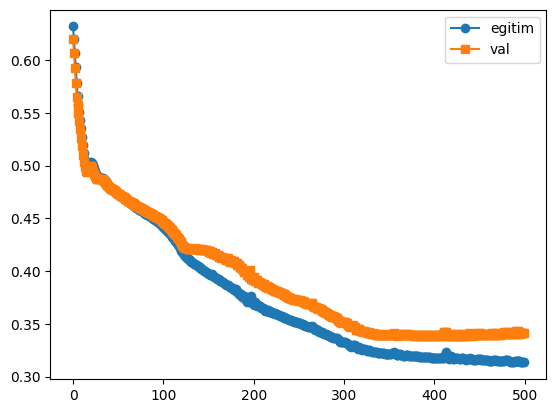

In [103]:
import matplotlib.pyplot as plt
plt.plot(torch.arange(500),egitim_kayiplar,label='egitim',marker='o')
plt.plot(torch.arange(500),val_kayiplar,label='val',marker='s')
plt.legend()
plt.show()

In [14]:
ciktilar=model(X_test)

In [83]:
ciktilar[:10]

tensor([[0.5725],
        [0.4380],
        [0.0722],
        [0.5130],
        [0.1751],
        [0.3390],
        [0.0040],
        [0.1952],
        [0.0390],
        [0.2979]], grad_fn=<SliceBackward0>)

In [84]:
sinif_tahminler=[]
for i in range(X_test.shape[0]):
  tahmin=ciktilar[i]
  if tahmin>=0.5:
    sinif_tahminler.append(1)
  else:
    sinif_tahminler.append(0)

In [21]:
sinif_tahminler=(ciktilar>=0.5).int()

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
accuracy_score(y_test,sinif_tahminler)

0.7904

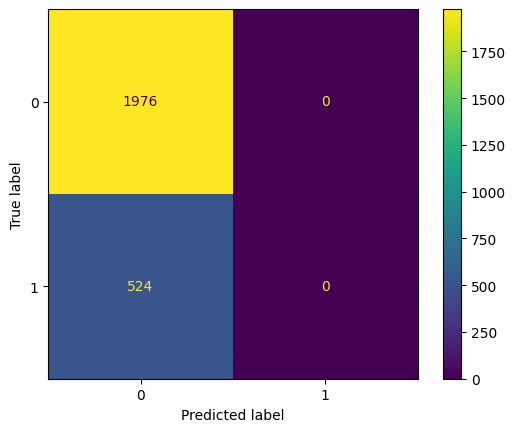

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(y_test,sinif_tahminler)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

#Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=0)

In [33]:
clf.fit(X_egitim, y_egitim)

RandomForestClassifier(max_depth=4, random_state=0)

In [35]:
rf_tahminler=clf.predict(X_test)

In [36]:
accuracy_score(y_test,rf_tahminler)

0.8292

#Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf = LogisticRegression(random_state=0).fit(X_egitim, y_egitim)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
lr_tahminler=clf.predict(X_test)

In [31]:
accuracy_score(y_test,lr_tahminler)

0.7856